# GNNs

- When we load this dataset using ImageFolder class from torchvision.
- We will also resize an crop the images 64x64 px 
- and normalize the pixel value with mean&Standard deviation of 0.5 for each channel.
- This will ensure that pixel values are in the range (-1,1), which is more convinient for traning the discriminator. 
- We will also create a data loader to load the data in batches.
- in normalize means substracted from pixel-value and divided bt SD

In [1]:
# imports
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
data_dir = 'data/animefaces/'
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [3]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))
train_dL = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

- we have normalized images (-1,1) range
- to denormalize here again. undoing division with multiplication, substraction with addition of SD, Mean

In [4]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# denormalize images to show
def denorm(img_tensors):
    return img_tensors * stats[1][0]+stats[0][0]

# here we multiply value with SD and add Mean to get denomal value of original pixel values

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(d1, nmax=64):
    for images, _ in d1:
        show_images(images, nmax)
        break

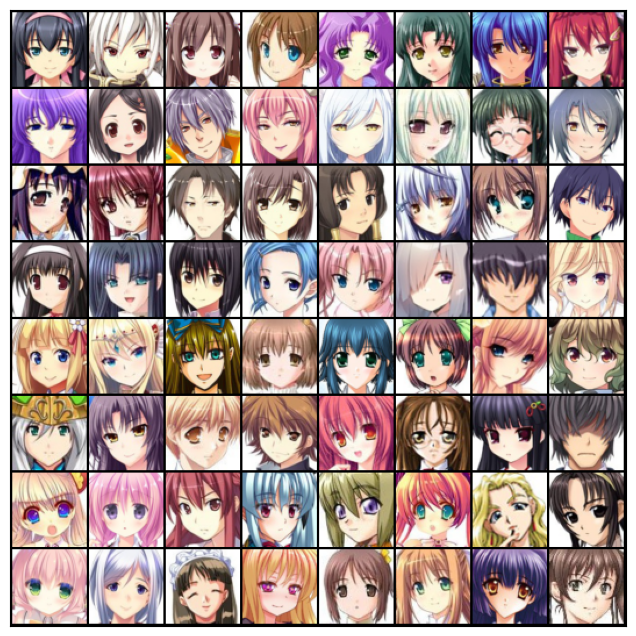

In [7]:
show_batch(train_dL)

# using A Gpu
To Seamlessly use a GPU, if one is available, we define a couple of helper functions(get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU, if one is available.

In [8]:
def get_default_device():
    ''' pick GPU if available, else CPU'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('CPU')

def to_device(data, device):
    '''Move tensors(s) to choosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dL, device):
        self.dL = dL
        self.device =device 
    
    def __iter__(self):
        '''Yield a batch of data after moving it to device'''
        for b in self.dL:
            yield to_device(b, self.device)

    def __len__(self):
        """number of batches"""
        return len(self.dL)

    

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dL = DeviceDataLoader(train_dL, device)
# now we have train_dL if any batche is the also moved to GPU

# Descriminator Network
- The discriminator takes an image as input, and tries to classify it as 'real' or 'generated'. In this sence, its's like any other neural network. 
- we'll use a convolutional neural network (CNN) which outputs a single nimber output for every image. 
- we will use a stride 2 to progressively reduce the size of the output feature map.

- **In generative adversarial networks (GANs)**, the discriminator is the **encoder**, while the generator is the **decoder**

- we have two networks inGNNs 
1. Generator
    - it takes random input and convert it to image
2. Discriminator
    - it detects the generated is generated or real
    - in a sence it is like a classifier.

### Using CNN Create Discriminator 

In [11]:
import torch.nn as nn
# Conv2d

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True), 
    # it handles (-Ve) values relu makes them '0'
    # this helps small value pass from discriminator to generator better
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False),
    # out: 1 x 1 x 1
    # we need 1 output from this only.

    nn.Flatten(),
    nn.Sigmoid()
    # sigmoid classifies output 0,1
)

In [13]:
discriminator = to_device(discriminator, device)

### Generator Network
- The input of the generator is typically a vector or a matrix of random numbers (referred to as latent tensor) which used as a seed for generatin images. 
- The genarator will convert a latent tensor of shape (128 ,1 ,1) into an image tensor of shape "3 x 28 x 28". 
- to achive this, we will use the ConvTranspose2d layer from pytorch, which performs as a trasposed convolution (also referred to as a **deconvolution**)

In [14]:
latent_size = 128
# ConvTranspose2d

In [38]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True), 
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True), 
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True), 
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True), 
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True), 
    # out: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64 (Tensor)
    # Tanh: it is Hyperbolic Tangent Function
    # this took puts output (-1, 1) range
    # We need to Denormalize this later to view as a image.
)

### Note:
- Since the outputs of the TanH activation lie in the range [-1,1], we have applied the similar transformation to the images in the training dataset. 
- let's generate some outputs using the generator and view them as images by transforming an denormalizing the output.

torch.Size([128, 3, 64, 64])


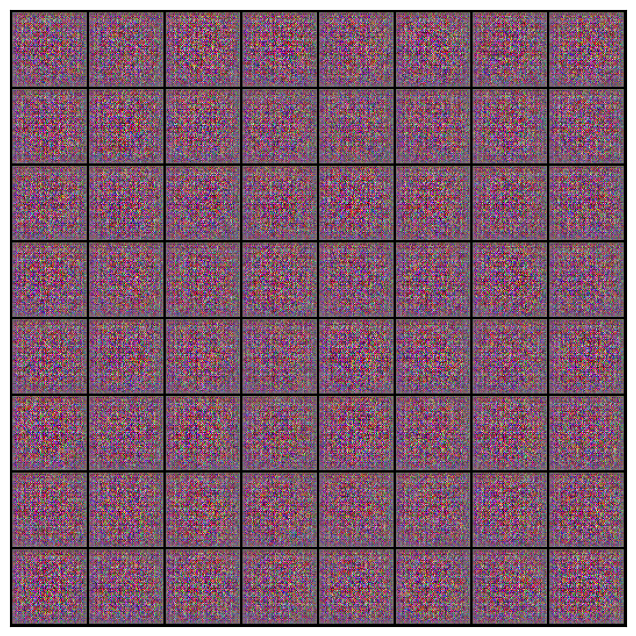

In [40]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensor
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

# output should be torch.size([128, 3, 64, 64])

As it is a latent run generator gives us random noice images only, we need to train it. lets move it to choosen device

In [41]:
generator = to_device(generator, device)

### Descriminator Training
since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quatify how well it is able to differenciate between real and generated images.

- **Entropy:** tells us mathematically how much the information is changed, rate of chane, differ from origu=inal state.

In [42]:
def train_discriminator(real_image, opt_d):
    # Clear discrimininator gradiants
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_image)
    real_targets = torch.ones(real_image.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.ones(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backwarg()
    # here gradiants will be caliculated
    opt_d.step()
    # optimizer apply here , we update weights.
    return loss.item(), real_score, fake_score   
# we use scores to to know how to train generator.

- Above we are passing real imges we get from DataLoder, fake images we get from generator.
- opt_d is optimizer for discriminator

### Steps in training Discriminator
- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and o if it was generated using the generator network
- we first pass a batch of real immages and compute loss setting the target label to 1.
- then we pass a batch of fake images (generated using the generator) pass them into the discriminatio, and compute loss, setting the target label to 0.
- finally we add the two losses and use the overall loss to perform gradiant descent to adjust the weights of the discriminator
- it's importent to note that we dont change the weights of the generator model while training the discriminator (opt_d only effects the descriminator.parameters())

### Generator training
Since the outputs of the generator are images, it's not obivious how we can train generator. this is where we employ a rather elegent trick, which is to use the discriminator as a part of the loss function. here's how it works.
- we generate a batch of images using the generator, pass the into the discriminator.
- we caliculate the loss by setting the target to 1 i.e. real. we do this because the generator's objective is to 'fool' the generator
- we use the loss to perform gradiant descent i.e. change the weights of the generator, so it gets better at generating real-like images to 'fool' the discriminator.
- here is the info

In [43]:
def train_generator(opt_g):
    # clear generator gradiants
    opt_g.zero_grad()

    # generate fake images 
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # try to fool discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # update generator weights
    loss.backward()
    opt_g.stpe()

    return loss.item()


- let's create directories to hold and save intermediate oututs from generator.
- create export function for gnerated images

In [44]:
from torchvision.utils import save_image
import os

In [45]:
# create direcotary
sample_dir = 'generated'
# os.makedirs(sample_dir)

In [46]:
# save images using function grid, index could be epoch number
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu(), nrow=8).permute(1, 2, 0))

- we will use a fixed set of inputs vectors to the generator to see how the individual generated images evolve over time as we train the model. lets save 1 set of images before train model.

In [47]:
fixed_latent = torch.randn(64, latent_size,1,1, device=device)
fixed_latent.shape

torch.Size([64, 128, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99962515..0.9977918].


saving generated-images-0000.png


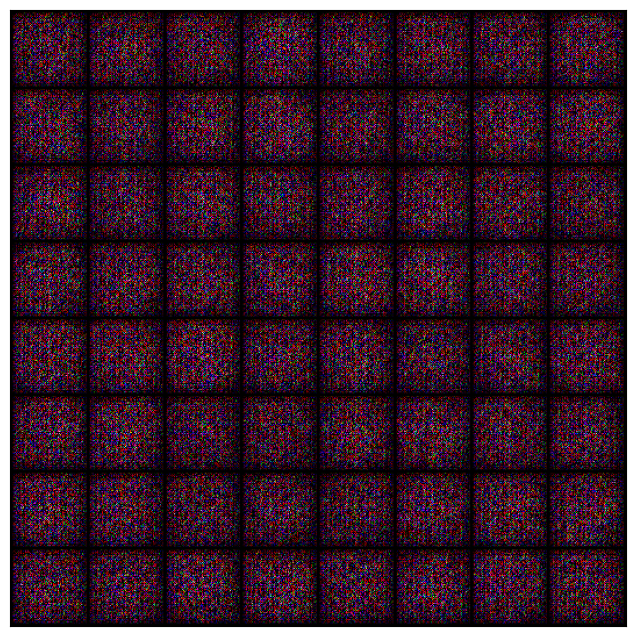

In [48]:
save_samples(0, fixed_latent)

### Full training loop
lets define a fit function to train the discriminator an generator in tandrem for each batch of training data. we will use the Adam Optimizer with some custome parameters (betas) that are known to work well for GANs. we will also save some sample generated imags at regular intervals for inspection.

In [49]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [50]:
def fit(epochs, lr, start_idx=1):
    # idx is for epoch we are sarting from
    torch.cuda.empty_cache()

    # losses & Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dL):
            # Train Discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & Scores
        losses_g.append(loss_g)
        losses_g.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log Losses & Scores (last batch)
        print('Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_scores: {:.4f}'.format
              (epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
    return losses_g, losses_d, real_scores, fake_scores

- we are now ready for train
- try different learning rates to see if you can maintaine the fine balance between training the generator and descriminator

In [51]:
lr = 0.0002
epochs = 10

# .log_hyper(lr=lr, epoch=epoch) ????

In [52]:
# pip install tqdm
# pip install ipywidgets

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history
## Log metrics 